In [1]:
# load global structural data
import pandas as pd
data = pd.read_csv('/data/sliu/updated_ukbb2/raw_data/matched_ukbb.csv')
total_items = pd.read_csv('/data/sliu/updated_ukbb2/raw_data/total_items.csv')
s1 = ['karin_IDs']
for i in range(total_items.shape[0]):
    s1.append(str(total_items.iloc[i,0])+'-2.0')
T_data = data[s1]
T_data.dropna(axis=0,how='any',inplace=True)

/data/sliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [2]:
# load covariates(age, sex, head positions, the top 25 principal components, head motion)
temp = pd.read_csv('/data/sliu/updated_ukbb/added_used_variables.csv')
s = ['eid','25756-2.0','25757-2.0','25758-2.0']
QC1 = temp[s]
temp2 = pd.read_csv('/data/sliu/muti_PRSs/ukb30545.sample_QC.csv')
s2 = ['eid','age_at_reqruitment','genetic_sex']
QC2 = temp2[s2]
PCs = pd.read_table('/data/sliu/muti_PRSs/UKB.HM3.EUR.100PCs.txt','\t')
PRS_data = pd.read_csv('/data/sliu/updated_ukbb/ukb_PRSs.csv')
s3 = ['karin_IDs','25741-2.0']
motion = data[s3]
motion.dropna(axis=0,how='any',inplace=True)

/data/sliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
/data/sliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [3]:
# load FC data
import os
import numpy as np
FC_path = '/data/sliu/updated_ukbb/FC/bulk_25752_updated/'
files = os.listdir(FC_path)
FC_IDs = []
FC_data = np.empty((len(files),210))
for i in range(len(files)):
    f = files[i]
    FC_IDs.append(int(f[:7]))
    try_data = np.loadtxt(os.path.join(FC_path,f))
#     try_data.reshape((1,210))
    FC_data[i,:] = try_data

In [4]:
# load ICA data
FC_path = '/data/sliu/updated_ukbb/FC/bulk_25754_updated/'
files = os.listdir(FC_path)
ICV_IDs = []
ICV_data = np.empty((len(files),21))
for i in range(len(files)):
    f = files[i]
    ICV_IDs.append(int(f[:7]))
    try_data = np.loadtxt(os.path.join(FC_path,f))
#     try_data.reshape((1,210))
    ICV_data[i,:] = try_data

In [5]:
# combine FC and ICA data together
fdata1 = pd.DataFrame(data=FC_data)
fdata1['IDs'] = np.array(FC_IDs)
fdata1.set_index('IDs',inplace=True)
fdata2 = pd.DataFrame(data=ICV_data)
fdata2['IDs'] = np.array(ICV_IDs)
fdata2.set_index('IDs',inplace=True)
ll = list(set(fdata1.index) & set(fdata2.index))
ffdata1 = fdata1.loc[ll]
ffdata2 = fdata2.loc[ll]
fdata = pd.concat([ffdata1,ffdata2],axis=1,join='inner')
fdata.reset_index(inplace=True)
fdata.drop_duplicates(['IDs'],inplace=True)

In [6]:
# matching subject IDs
T_data.set_index('karin_IDs', inplace=True)
fdata.set_index('IDs',inplace=True)
motion.set_index('karin_IDs', inplace=True)
QC1.set_index('eid',inplace=True)
QC2.set_index('eid',inplace=True)
PCs.set_index('IID',inplace=True)
PRS_data.set_index('FID',inplace=True)
l = list(set(fdata.index) & set(T_data.index) & set(QC1.index) & set(QC2.index) & set(motion.index)\
         & set(PCs.index) & set(PRS_data.index))
final_FCs = fdata.loc[l]
final_Ts = T_data.loc[l]
final_QC1 = QC1.loc[l]
final_QC2 = QC2.loc[l]
final_PCs = PCs.loc[l]
final_motion = motion.loc[l]
final_PRSs = PRS_data.loc[l]

final_FCs.reset_index(inplace=True)
final_Ts.reset_index(inplace=True)
final_QC1.reset_index(inplace=True)
final_QC2.reset_index(inplace=True)
final_PCs.reset_index(inplace=True)
final_motion.reset_index(inplace=True)
final_PRSs.reset_index(inplace=True)

In [7]:
# merge covariates together 
PCs_25 = final_PCs.iloc[:,2:27].values
age = final_QC2.iloc[:,1:2].values
sex = final_QC2.iloc[:,2:3].values
motion = final_motion.iloc[:,1:2].values
postions = final_QC1.iloc[:,1:4].values

In [8]:
TA = (final_Ts.iloc[:,1:2].values + final_Ts.iloc[:,2:3].values)/2
AT = (final_Ts.iloc[:,3:4].values + final_Ts.iloc[:,4:5].values)/2
ICV = final_Ts.iloc[:,5:6].values

In [9]:
sex = sex + 1
co1 = np.hstack((PCs_25,age,sex,age*age,age*sex,age*age*sex,postions,motion))
co2 = np.hstack((PCs_25,age,sex,age*age,age*sex,age*age*sex,postions,motion,TA,AT,ICV))

In [10]:
# function used for regressing out the effects of covariates 
from sklearn.preprocessing import StandardScaler

def regression_covariant(covariant_matrix, y, standard_scale=False):
    a = np.hstack((covariant_matrix,np.ones((covariant_matrix.shape[0], 1))))
    w = np.linalg.lstsq(a,y,rcond=None)[0]

    residual = y - covariant_matrix.dot(w[:-1])
    residual = residual.astype('float64')

    if standard_scale:
        residual = StandardScaler().fit_transform(residual.reshape(-1,1)).flatten()

    return residual, w

In [11]:
# Pearson's correlation analysis between PRSs and functional measures
from scipy.stats import pearsonr
X = final_PRSs.iloc[:,1:].values
X[:,7] = -X[:,7]
X[:,8] = -X[:,8]
X[:,11] = -X[:,11]
Y = final_FCs.iloc[:,1:].values
R = np.zeros((X.shape[1],Y.shape[1]))
P = np.ones((X.shape[1],Y.shape[1]))
for i in range(X.shape[1]):
    for j in range(Y.shape[1]):
        x = X[:,i]
        y = Y[:,j]
        [rx,w1] = regression_covariant(co1,x,standard_scale=True)
        [ry,w1] = regression_covariant(co1,y,standard_scale=True)
        r,p = pearsonr(rx, ry)
        R[i,j] = r
        P[i,j] = p

In [12]:
# FDR multiple comparison correction
from statsmodels.stats import multitest
size = P.shape
temp_p = P.flatten()
Ps = multitest.multipletests(temp_p,alpha=0.05,method='fdr_bh')
P_corrected = Ps[1].reshape(size)

In [13]:
# output results
data1 = pd.DataFrame(data=R)
data1.to_csv('/data/sliu/updated_ukbb2/FC_results/FC_R.csv',header=None,index=False)
data2 = pd.DataFrame(data=P)
data2.to_csv('/data/sliu/updated_ukbb2/FC_results/FC_P.csv',header=None,index=False)
data3 = pd.DataFrame(data=P_corrected)
data3.to_csv('/data/sliu/updated_ukbb2/FC_results/FC_P_corrected.csv',header=None,index=False)

In [14]:
PRS_names = final_PRSs.columns.values[1:]

In [41]:
# show significant FCs
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import circular_layout, plot_connectivity_circle
from matplotlib import colors as mcolors
label_names = []
for i in range(21):
    label_names.append(i+1)
colors = list(mcolors.CSS4_COLORS.values())
selected_colors = colors[15:36]
selected_colors[9] = colors[37]
selected_colors[3] = colors[40]
selected_colors[5] = colors[41]
selected_colors[1] = colors[48]
selected_colors[13] = colors[46]

In [42]:
selected_colors[0]

'#D2691E'

In [43]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)

In [44]:
np.sum(P_corrected[:,:210]<0.0167)

133

ADHD_2017 5


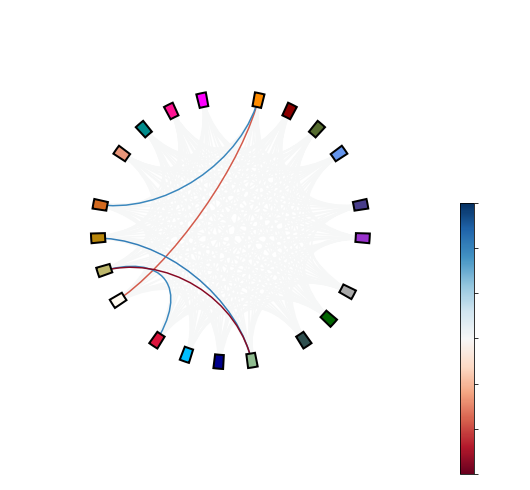

alzheimer 0
autism 8


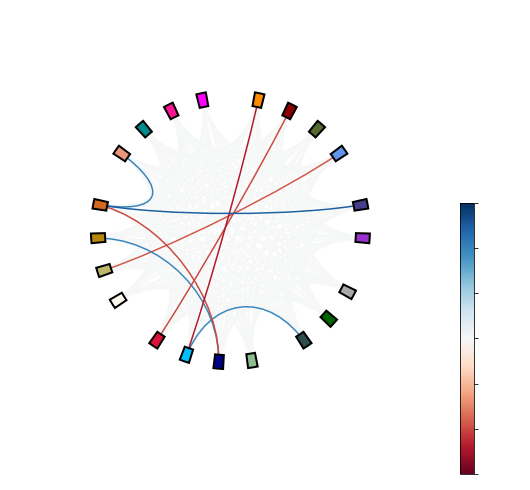

bipolar 5


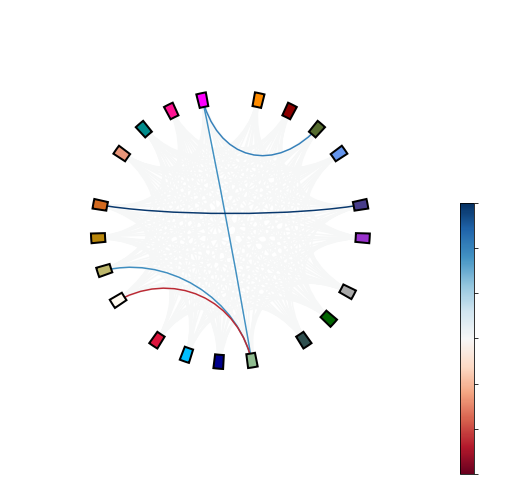

eating_disorder 2


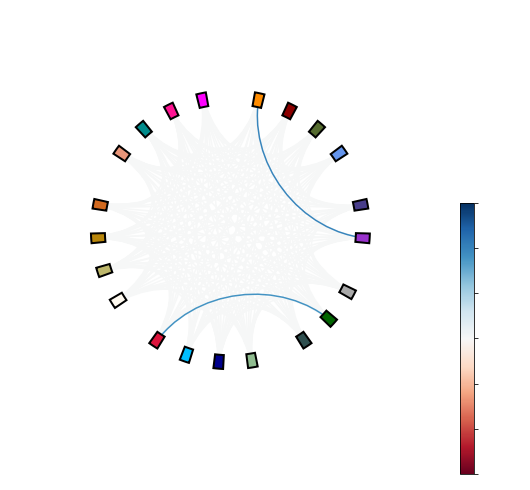

MDD 12


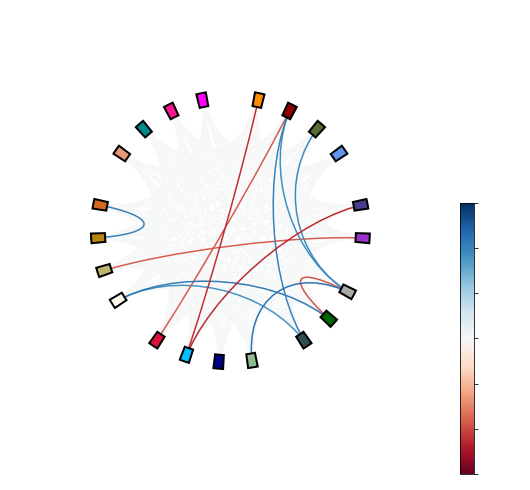

schizophrenia 43


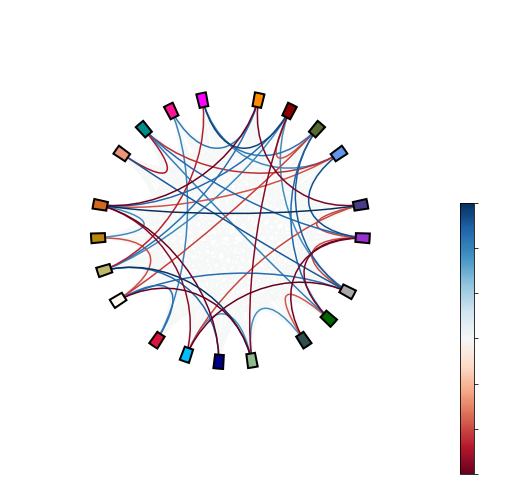

cigarettes_per_day 1


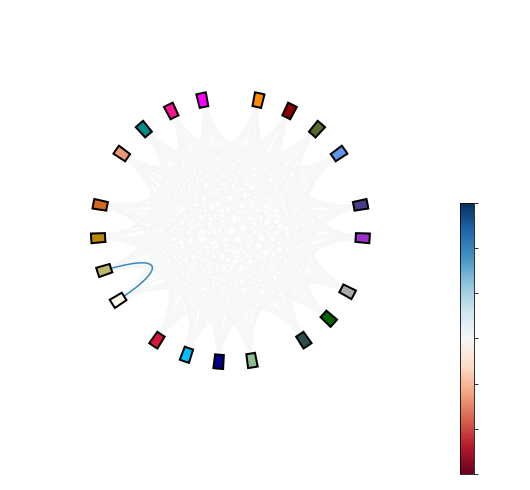

smoking_initiation 1


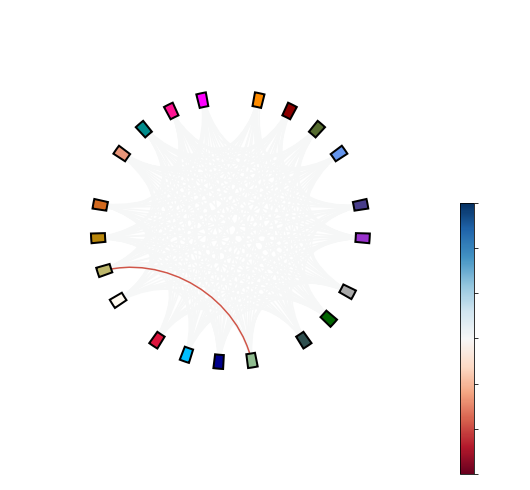

smoking_cessation 1


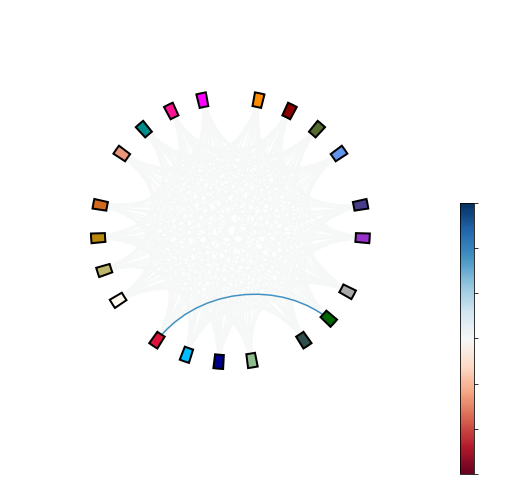

caffeine 2


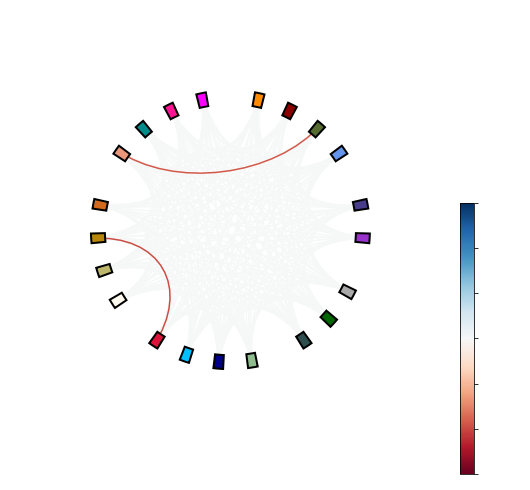

drinks_per_week 2


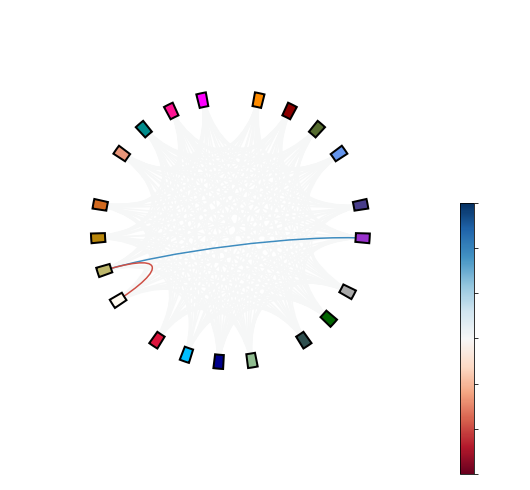

cognitive_ability 5


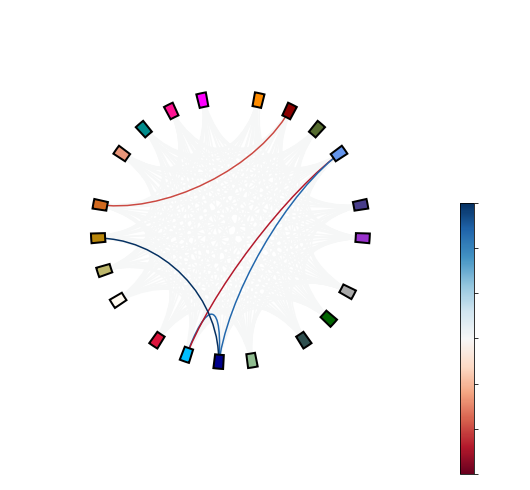

educational_attainment 46


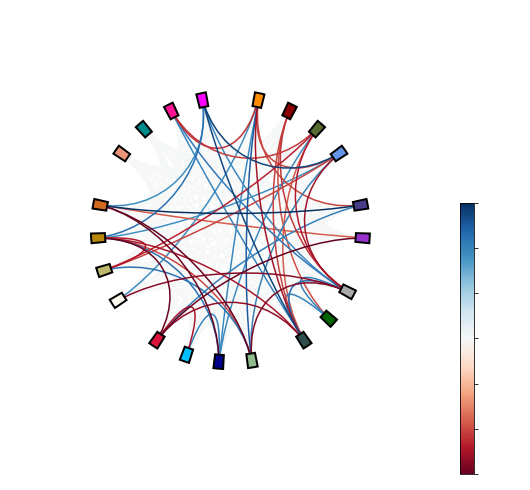

In [49]:
import os
path1 = '/data/sliu/updated_ukbb2/Figures/FC'
FC_info = pd.read_csv('/data/sliu/updated_ukbb/edge_list_d25.txt',sep=' ')
node_order =[2,4,8,19,1,9,13,14,5,6,7,20,10,11,12,17,21,3,15,18,16]
boundaries = [0,4,8,12,15,17]
node_angles = circular_layout(label_names, node_order, start_pos=90, group_boundaries=boundaries)
# cmaps = ['RdBu','Reds','Blues']
for i in range(X.shape[1]):
    temp_R = R[i,:210]
    temp_P = P_corrected[i,:210]
    FC_matrix = np.zeros((21,21))
    FC_num = np.sum(temp_P<0.0167)
    print(PRS_names[i],FC_num)
    if FC_num == 0:
        continue
    for j in range(210):
        if temp_P[j] < 0.0167:
            x = FC_info.iloc[j,1] - 1
            y = FC_info.iloc[j,2] - 1
            FC_matrix[x,y] = temp_R[j]
            FC_matrix[y,x] = temp_R[j]
             
    fig = plt.figure(figsize=(10,10))    
#     ax = plot_connectivity_circle(FC_matrix, label_names, vmin = -0.03, vmax = 0.03, facecolor = 'white', textcolor = 'black',
#                          node_angles=node_angles, node_colors=selected_colors, colormap='RdBu', fig=fig,colorbar_size=0.5,
#                          fontsize_colorbar=14,fontsize_names=14)
    ax = plot_connectivity_circle(FC_matrix, label_names, vmin = -0.03, vmax = 0.03, facecolor = 'white', textcolor = 'white',
                         node_angles=node_angles, node_width = 4, node_colors=selected_colors, colormap='RdBu', fig=fig,colorbar_size=0.5,
                         fontsize_colorbar=14,fontsize_names=14)
    output_path = os.path.join(path1,PRS_names[i]+'.png')
    fig.savefig(output_path,dpi=300,bbox_inches = 'tight')  

In [26]:
node_R = R[:,210:]
node_P = P_corrected[:,210:]
re_node_R = pd.DataFrame(data=node_R)
re_node_P = pd.DataFrame(data=node_P)
re_node_R.to_csv('/data/sliu/updated_ukbb2/FC_results/nodes_R.csv',index=False,header=None)
re_node_P.to_csv('/data/sliu/updated_ukbb2/FC_results/nodes_P.csv',index=False,header=None)